In [3]:
# =============================================
# Hate Speech Detection in Tweets
# Advanced Text Classification with RNN, LSTM, and Word2Vec
# =============================================

# Import Libraries
import pandas as pd
import numpy as np
import re
import string
import contractions
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

from sklearn.utils import class_weight

# TensorFlow/Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Gensim for Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /home/samyog/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/samyog/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# =============================================
# 1. Data Loading and Preprocessing
# =============================================

def clean_text(text):
    """Clean raw text by removing URLs, mentions, hashtags, etc."""
    text = text.lower()
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r"http\S+|www\S+", "", text)           # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)                # Remove mentions/hashtags
    text = re.sub(r"\d+", "", text)                      # Remove numbers
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = text.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    text = re.sub(r"\s+", " ", text).strip()             # Remove extra spaces
    return text

def preprocess(text):
    """Apply lemmatization and stopword removal."""
    text = clean_text(text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Load datasets
train_df = pd.read_csv("/media/samyog/My Folder/AI and ML/Others/Training_2/train_racisit.csv")  # Columns: 'tweet', 'label'
test_df = pd.read_csv("/media/samyog/My Folder/AI and ML/Others/Training_2/test_racisit.csv")    # Columns: 'tweet'

# Preprocess text
train_df['cleaned_tweet'] = train_df['tweet'].apply(preprocess)
test_df['cleaned_tweet'] = test_df['tweet'].apply(preprocess)


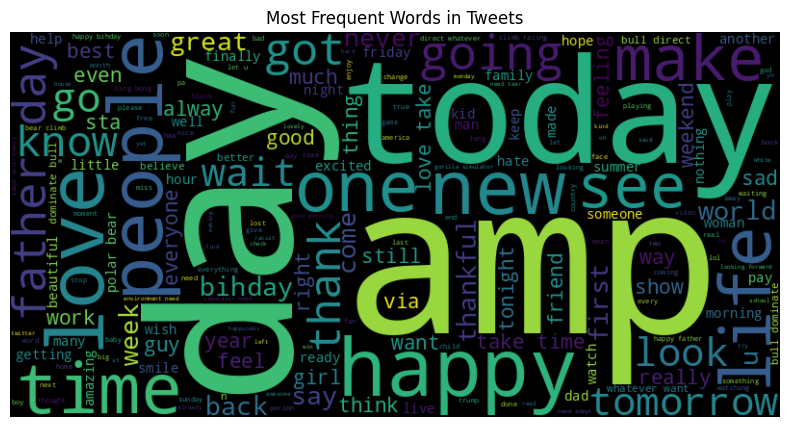

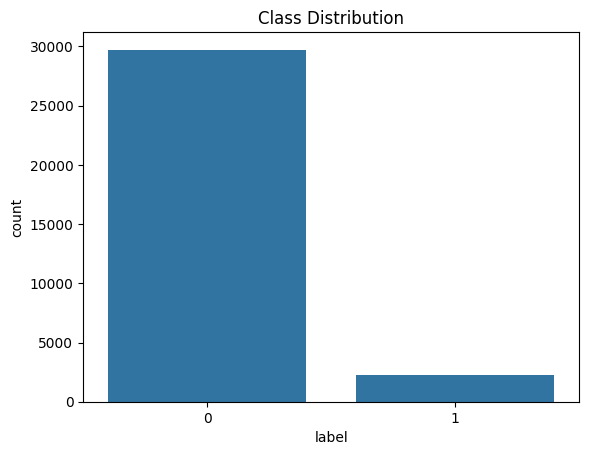

In [6]:
# =============================================
# 2. Exploratory Data Analysis (EDA)
# =============================================

# Word Cloud
all_words = ' '.join(train_df['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Tweets")
plt.show()

# Label Distribution (if applicable)
if 'label' in train_df:
    sns.countplot(x=train_df['label'])
    plt.title("Class Distribution")
    plt.show()


In [7]:
# =============================================
# 3. Tokenization and Padding
# =============================================

X = train_df['cleaned_tweet']
y = train_df['label']

# Split into train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_tweet'])

# Calculate 95th percentile sequence length for padding
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Padding sequences to length: {max_len}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1  # +1 for OOV tokens


Padding sequences to length: 11


In [8]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


In [14]:
# =============================================
# 4. Model 1: Simple RNN
# =============================================

model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),  # Regularization
    Dense(1, activation='sigmoid')
])

model_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)


/media/samyog/My Folder/AI and ML/Others/Training_2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.7125 - loss: 0.5594 - val_accuracy: 0.8846 - val_loss: 0.3271
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.9407 - loss: 0.1810 - val_accuracy: 0.9126 - val_loss: 0.2368
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.9752 - loss: 0.0867 - val_accuracy: 0.8785 - val_loss: 0.3019
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.9763 - loss: 0.0683 - val_accuracy: 0.9263 - val_loss: 0.2456
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.9855 - loss: 0.0437 - val_accuracy: 0.9029 - val_loss: 0.3069


In [15]:
# =============================================
# 5. Model 2: Bidirectional LSTM
# =============================================

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),  # Bidirectional for context
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.7728 - loss: 0.5522 - val_accuracy: 0.8550 - val_loss: 0.3687
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.9209 - loss: 0.2211 - val_accuracy: 0.9065 - val_loss: 0.2686
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.9636 - loss: 0.1213 - val_accuracy: 0.9032 - val_loss: 0.2758
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.9728 - loss: 0.0779 - val_accuracy: 0.9293 - val_loss: 0.2832
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.9817 - loss: 0.0625 - val_accuracy: 0.9246 - val_loss: 0.3232


In [16]:
# =============================================
# 6. Model 3: LSTM with Pretrained Word2Vec
# =============================================

# Load pretrained Word2Vec embeddings
word2vec_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional embeddings
embedding_dim = 100

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)  # Random for OOV

model_w2v = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # Freeze embeddings
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_w2v.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_w2v = model_w2v.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7268 - loss: 0.5500 - val_accuracy: 0.8323 - val_loss: 0.4073
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8259 - loss: 0.4005 - val_accuracy: 0.8405 - val_loss: 0.4034
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8320 - loss: 0.3697 - val_accuracy: 0.8376 - val_loss: 0.3841
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8440 - loss: 0.3388 - val_accuracy: 0.8528 - val_loss: 0.3456
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8694 - loss: 0.2919 - val_accuracy: 0.8451 - val_loss: 0.3897
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8933 - loss: 0.2435 - val_accuracy: 0.8656 - val_loss: 0.3298
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9075 - loss: 0.2098 - val_accuracy: 0.8705 - val_loss: 0.3159
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9192 - loss: 0.1854 - val_accur


                          SIMPLE RNN MODEL PERFORMANCE                          


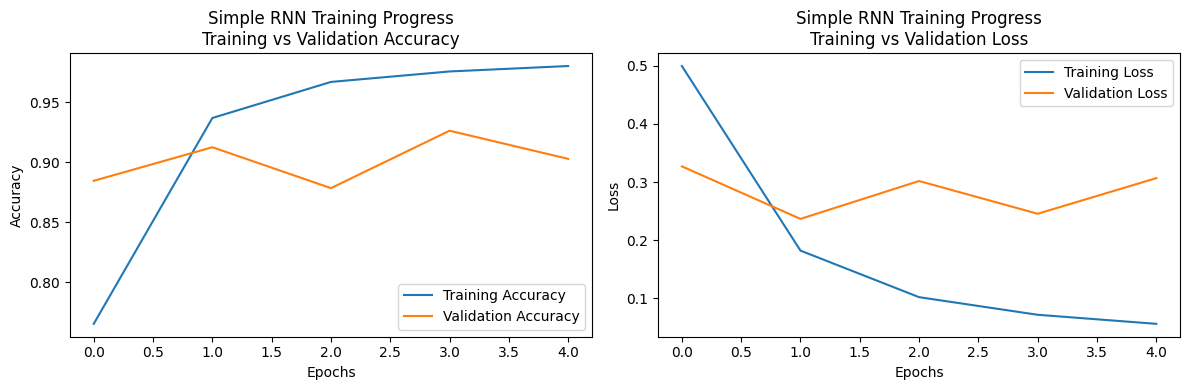

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
════════════════════════════════════════════════════════════
EVALUATION REPORT: SEQUENTIAL_1
════════════════════════════════════════════════════════════

Overall Accuracy: 0.9126

Confusion Matrix:
[[5528  409]
 [ 150  306]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9736    0.9311    0.9519      5937
           1     0.4280    0.6711    0.5226       456

    accuracy                         0.9126      6393
   macro avg     0.7008    0.8011    0.7373      6393
weighted avg     0.9347    0.9126    0.9213      6393

════════════════════════════════════════════════════════════


                      BIDIRECTIONAL LSTM MODEL PERFORMANCE                      


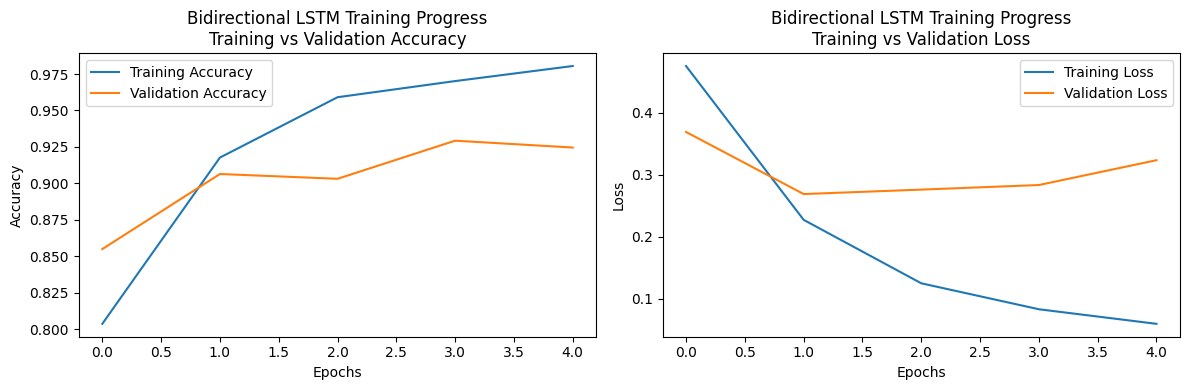

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
════════════════════════════════════════════════════════════
EVALUATION REPORT: SEQUENTIAL_2
════════════════════════════════════════════════════════════

Overall Accuracy: 0.9065

Confusion Matrix:
[[5482  455]
 [ 143  313]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9746    0.9234    0.9483      5937
           1     0.4076    0.6864    0.5114       456

    accuracy                         0.9065      6393
   macro avg     0.6911    0.8049    0.7299      6393
weighted avg     0.9341    0.9065    0.9171      6393

════════════════════════════════════════════════════════════


                        WORD2VEC LSTM MODEL PERFORMANCE                         


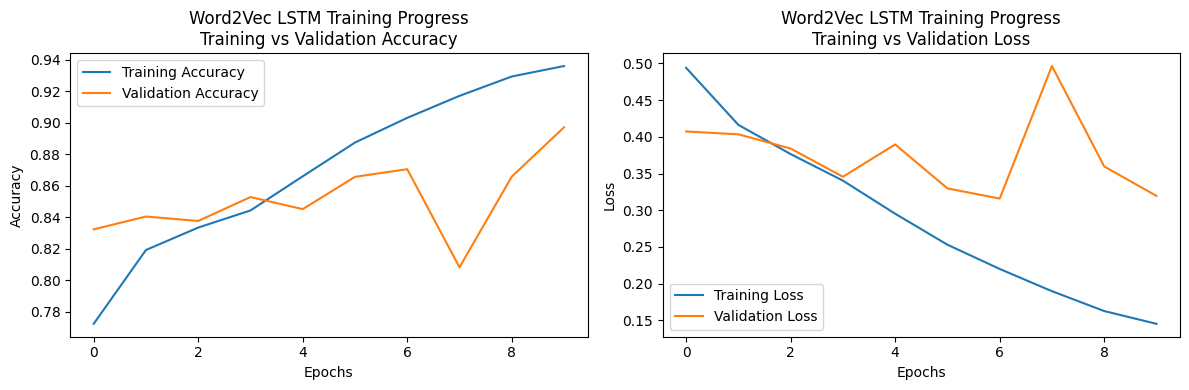

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
════════════════════════════════════════════════════════════
EVALUATION REPORT: SEQUENTIAL_3
════════════════════════════════════════════════════════════

Overall Accuracy: 0.8705

Confusion Matrix:
[[5227  710]
 [ 118  338]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9779    0.8804    0.9266      5937
           1     0.3225    0.7412    0.4495       456

    accuracy                         0.8705      6393
   macro avg     0.6502    0.8108    0.6880      6393
weighted avg     0.9312    0.8705    0.8926      6393

════════════════════════════════════════════════════════════



In [17]:
# =============================================
# 7. Enhanced Model Evaluation with Visualization
# =============================================

from sklearn.metrics import accuracy_score

def plot_training_performance(history, model_name):
    """Visualize model training/validation metrics over epochs."""
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name}\nTraining vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name}\nTraining vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_classification_performance(model, X_test, y_test):
    """Comprehensive evaluation of model performance with metrics."""
    y_pred = model.predict(X_test).round()
    acc = accuracy_score(y_test, y_pred)
    
    print("═"*60)
    print(f"EVALUATION REPORT: {model.name.upper()}")
    print("═"*60)
    print(f"\nOverall Accuracy: {acc:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("═"*60 + "\n")

# Visualize and evaluate each model
print("\n" + "="*80)
print("SIMPLE RNN MODEL PERFORMANCE".center(80))
print("="*80)
plot_training_performance(history_rnn, "Simple RNN Training Progress")
evaluate_classification_performance(model_rnn, X_val_pad, y_val)

print("\n" + "="*80)
print("BIDIRECTIONAL LSTM MODEL PERFORMANCE".center(80))
print("="*80)
plot_training_performance(history_lstm, "Bidirectional LSTM Training Progress")
evaluate_classification_performance(model_lstm, X_val_pad, y_val)

print("\n" + "="*80)
print("WORD2VEC LSTM MODEL PERFORMANCE".center(80))
print("="*80)
plot_training_performance(history_w2v, "Word2Vec LSTM Training Progress")
evaluate_classification_performance(model_w2v, X_val_pad, y_val)

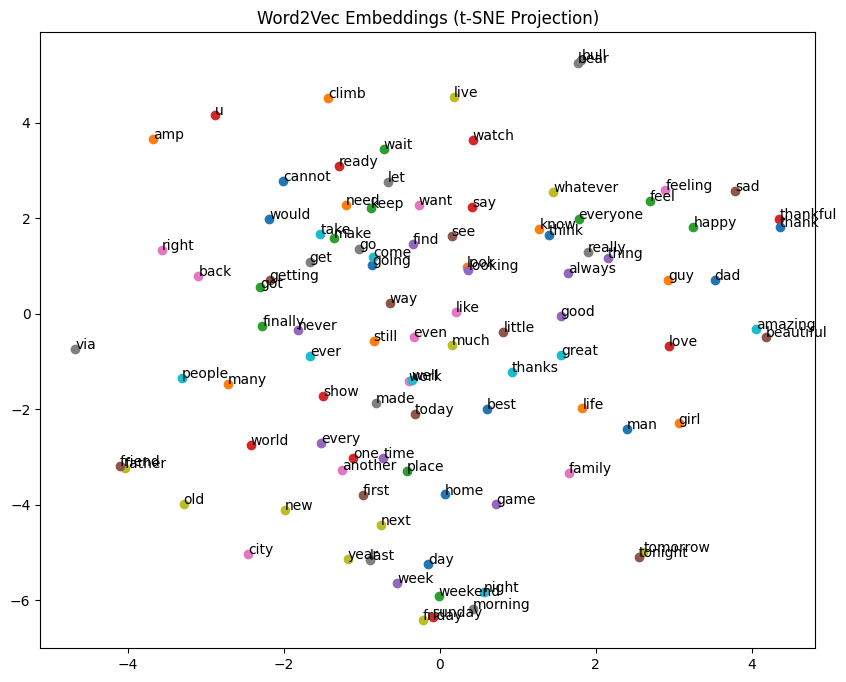

In [18]:
# =============================================
# 8. Visualize Word Embeddings (t-SNE)
# =============================================

# Sample 100 words from vocabulary
sample_words = list(tokenizer.word_index.keys())[:100]
sample_vectors = [word2vec_model[w] for w in sample_words if w in word2vec_model]

# Ensure sample_words and sample_vectors are aligned
sample_words = [w for w in sample_words if w in word2vec_model]

# Convert list to NumPy array
sample_vectors = np.array(sample_vectors)

# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(sample_vectors)

# Plot
plt.figure(figsize=(10, 8))
for i, word in enumerate(sample_words):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]))
plt.title("Word2Vec Embeddings (t-SNE Projection)")
plt.show()


In [19]:
# =============================================
# 9. Real-Time Prediction GUI (Gradio)
# =============================================

import gradio as gr


def predict_hate_speech(text):
    """Predict hate speech label for input text."""
    text = preprocess(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_lstm.predict(padded).round()[0][0]
    return "Hate Speech" if pred == 1 else "Not Hate Speech"

# Launch GUI
gr.Interface(
    fn=predict_hate_speech,
    inputs=gr.Textbox(label="Enter Tweet"),
    outputs=gr.Label(label="Prediction"),
    title="Hate Speech Detector",
    description="Classify tweets as Hate Speech or Not using Bidirectional LSTM"
).launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [20]:
# =============================================
# 10. Save Predictions
# =============================================

test_preds = model_lstm.predict(X_test_pad).round().astype(int)
submission = test_df.copy()
submission['prediction'] = test_preds
submission.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to 'test_predictions.csv'")

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
Test predictions saved to 'test_predictions.csv'
